# Load images

In [1]:
import os
import numpy as np
from PIL import Image # OpenCV does not support opening GIFs

# Get image filenames
filenames = [fn for fn in os.listdir("images") if os.path.isfile(f"images/{fn}")]

# Creates a list of dict in the format of ...
# [{'filename': <file name of image>, 'image': <numpy array of pixel values>}, ...]
images = []
for filename in filenames:
    image_path = f"images/{filename}"
    with Image.open(image_path) as img:
        img = np.array(img, dtype=bool)
    images.append({'filename': filename, 'image': img})

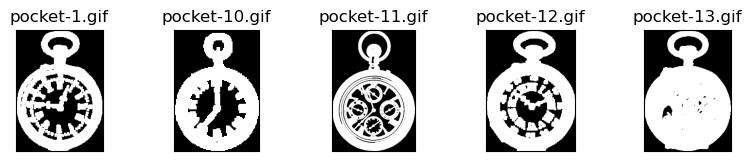

In [2]:
from utils import image_show

imgs = [img['image'] for img in images[340:345]]
fns = [img['filename'] for img in images[340:345]]
image_show(imgs, fns)

# Pre-processing

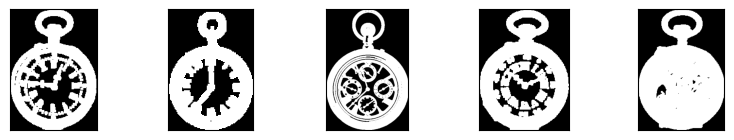

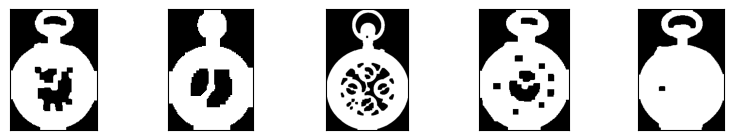

In [3]:
import cv2

imgs = [im['image'] for im in images[340:345]]
kernel = np.ones((3, 3), np.uint8)

imgs_closed = []
for img in imgs:
    img = img.astype(np.uint8)
    img = cv2.dilate(img, kernel, iterations=4)
    img = cv2.erode(img, kernel, iterations=4)
    img = img.astype(bool)
    imgs_closed.append(img)

image_show(imgs)
image_show(imgs_closed)

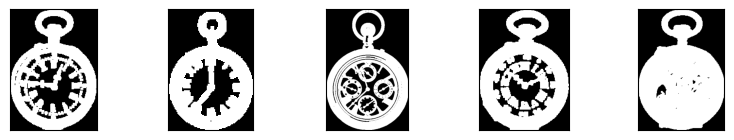

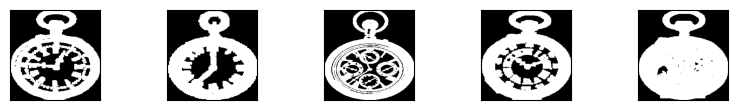

In [4]:
imgs = [im['image'] for im in images[340:345]]
kernel = np.ones((3, 3), np.uint8)

imgs_resized = []
for img in imgs:
    img = Image.fromarray(img)
    img = img.resize((224, 224), resample=Image.Resampling.LANCZOS)
    img = np.array(img, dtype=bool)
    imgs_resized.append(img)

image_show(imgs)
image_show(imgs_resized)

In [5]:
import cv2

for index, image in enumerate(images):
    image = image['image']
    
    # Closing and opening
    kernel = np.ones((3, 3), np.uint8)
    image = image.astype(np.uint8)
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
    image = image.astype(bool)
    
    # Resize to 224 x 224 and convert to RGB for input into CNN
    image = Image.fromarray(image)
    image = image.resize((224, 224), resample=Image.Resampling.LANCZOS)
    image = image.convert('RGB')
    image = np.array(image)
    
    images[index]['image'] = image

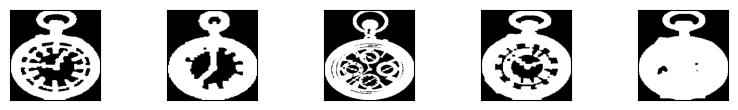

In [6]:
imgs = [im['image'] for im in images[340:345]]
image_show(imgs)

# Feature extraction

In [7]:
import torch
from torchvision import transforms
from torchvision.models import mobilenet_v3_large

model = mobilenet_v3_large(weights="IMAGENET1K_V1")
model.classifier = torch.nn.Identity() # Remove classifier layer
model.eval()
model = torch.jit.script(model) # JIT optimize model
model = torch.jit.optimize_for_inference(model) # Fuse batch norm + cnn layers

In [8]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [9]:
from tqdm.auto import tqdm

features = {}
with torch.inference_mode():
    for img in tqdm(images):
        filename = img['filename']
        image = img['image']
        
        # Tensorize, normalize, and add batch dimension
        image = transform(image)
        image = image.unsqueeze(0)
        
        # Extract features
        feature = model(image)
        
        # Remove batch dimension and convert features to numpy array
        feature = feature.squeeze(0)
        feature = feature.detach().cpu().numpy()
        
        features.update({filename: feature})

  0%|          | 0/400 [00:00<?, ?it/s]

# Save features

In [10]:
import pickle

with open("features.pickle", 'wb') as file:
    pickle.dump(features, file)